# <center>Planar Flow [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

from utils.NF_base import *
from utils.training_unnormalized_densities import *
from utils.training_vae import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**Planar Flows**
\begin{equation*}
    z'=z+uh(w^Tz+b)
\end{equation*}
with h a piecewise non linearity (e.g. tanh).

The Jacobian is then:
\begin{align*}
    J_T(z) = I+h'(w^Tz+b)uw^T
\end{align*}
Then, the determinant of the Jacobian is:
\begin{align*}
    \det J_T(z) &= \det(I+h'(w^Tz+b)uw^T) \\
    &= \det(1+h'(w^Tz+b)w^Tu) \text{ by the matrix determinant lemma: }\det(A+VW^T)=\det(I+W^TA^{-1}V)\det(A)
\end{align*}


Problem: invertible only if $w^Tu>-1$. and no closed-form solution (can't be trained as usual).
To train it, we  normalize here the reverse KL-divergence for with we have to be able to evaluate the target density:

\begin{equation*}
    \min\limits_\theta KL((T_\theta)_\# p_Z||p_X^*)
\end{equation*}

and we have:
\begin{align*}
    KL((T_\theta)_\# p_Z||p_X^*) &= \mathbb{E}_{p_Z}[\log p_Z(z) - \log|\det J_T(z)|-\log p_X^*(T(z))]
\end{align*}

We can approximate it by Monte-Carlo if we can evaluate $p_X^*$.


## Unnormalized 2D densities

Target: $p(z)\propto e^{-U(z)}$

(https://arxiv.org/pdf/1505.05770.pdf)

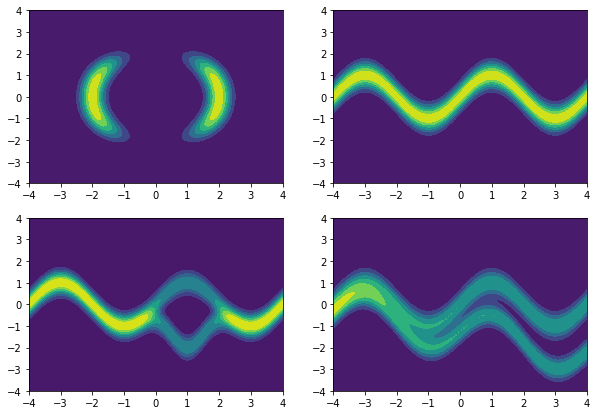

In [3]:
xline = np.linspace(-4, 4, 100)
yline = np.linspace(-4, 4, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

zz = np.exp(-U1(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid1 = zz.reshape(100,100)

zz = np.exp(-U2(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid2 = zz.reshape(100,100)

zz = np.exp(-U3(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid3 = zz.reshape(100,100)

zz = np.exp(-U4(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid4 = zz.reshape(100,100)

fig,ax = plt.subplots(2,2,figsize=(10,7))

ax[0,0].contourf(xgrid, ygrid, zgrid1)
ax[0,1].contourf(xgrid, ygrid, zgrid2)
ax[1,0].contourf(xgrid, ygrid, zgrid3)
ax[1,1].contourf(xgrid, ygrid, zgrid4)
plt.show()

### $U_1$

In [4]:
planarFlows = [PlanarFlow(2) for k in range(32)]
model = NormalizingFlows(planarFlows)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  160


In [5]:
train_loss = train_shapes(model, optimizer, U=U1p, n_epochs=1000)

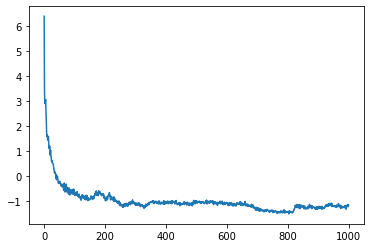

In [6]:
plt.plot(train_loss)
plt.show()

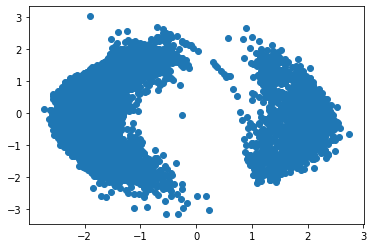

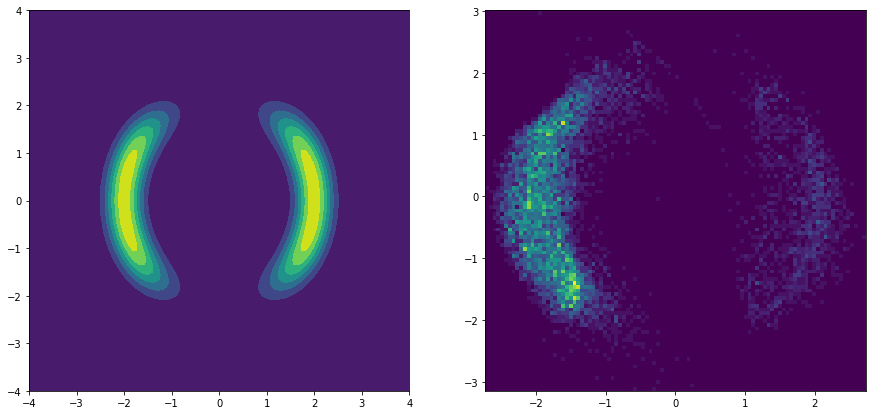

In [7]:
z,_ = model(torch.randn(10000,2,device=device))
samples = z[-1].detach().cpu().numpy()

plt.scatter(samples[:,0],samples[:,1])
plt.show()

fig,ax = plt.subplots(1,2,figsize=(15,7))

ax[0].contourf(xgrid, ygrid, zgrid1)
ax[1].hist2d(samples[:,0],samples[:,1],bins=100)
plt.show()

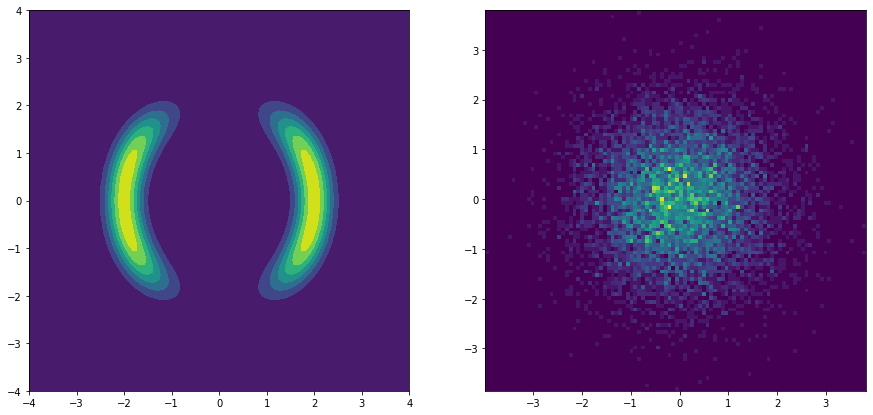

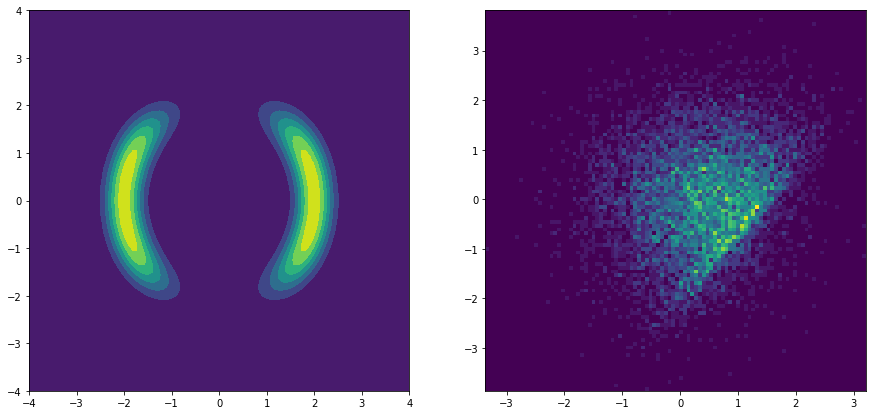

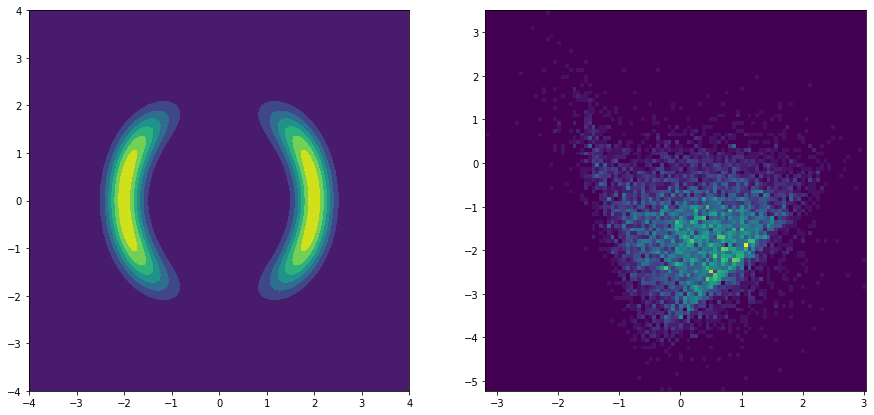

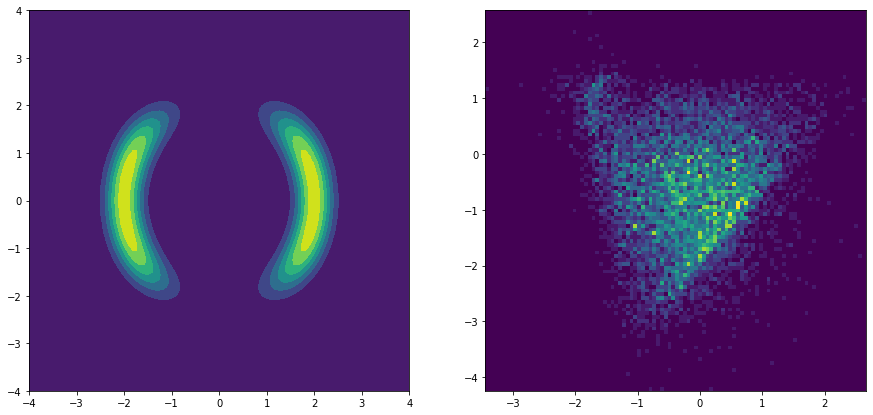

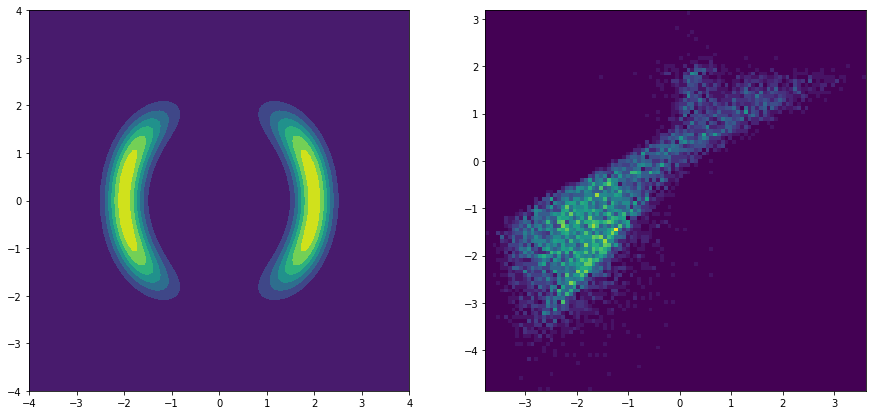

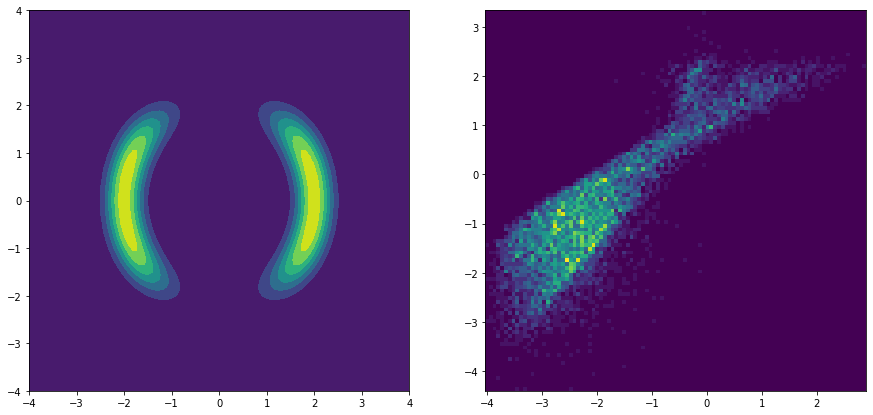

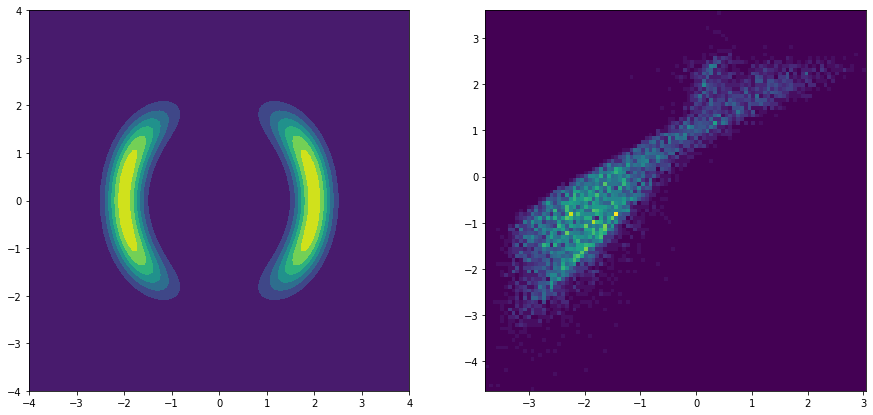

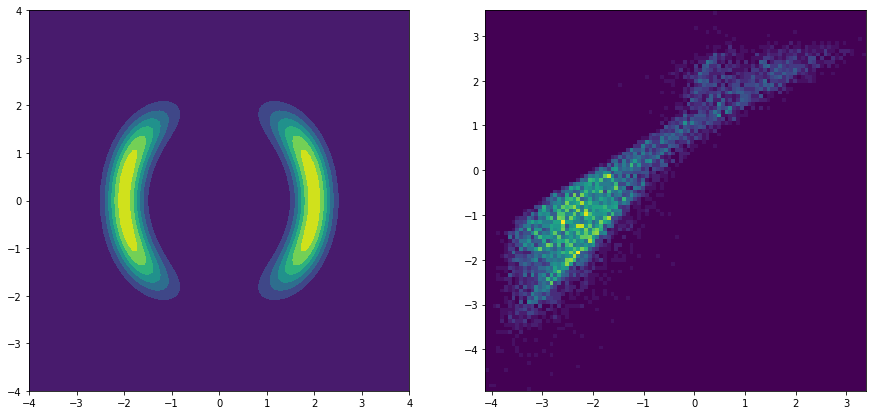

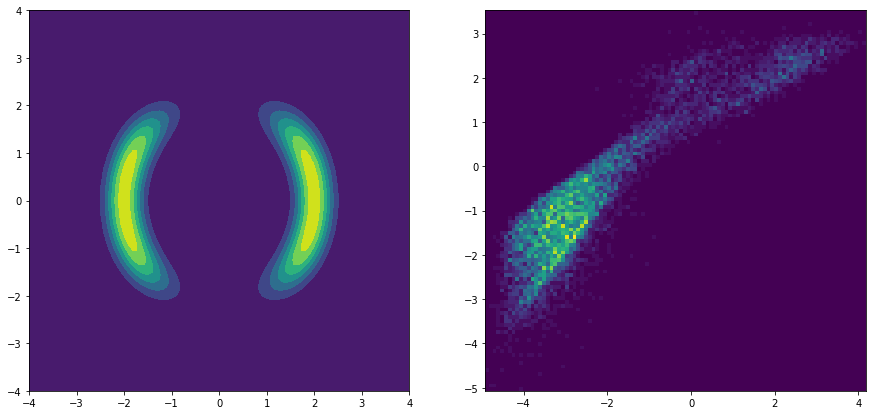

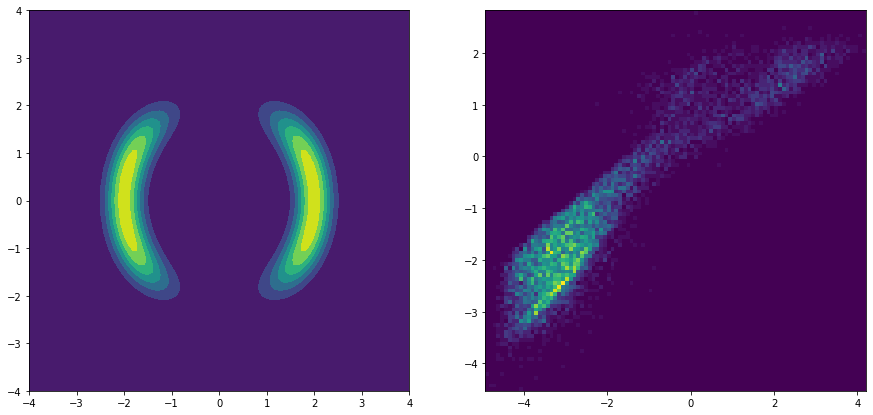

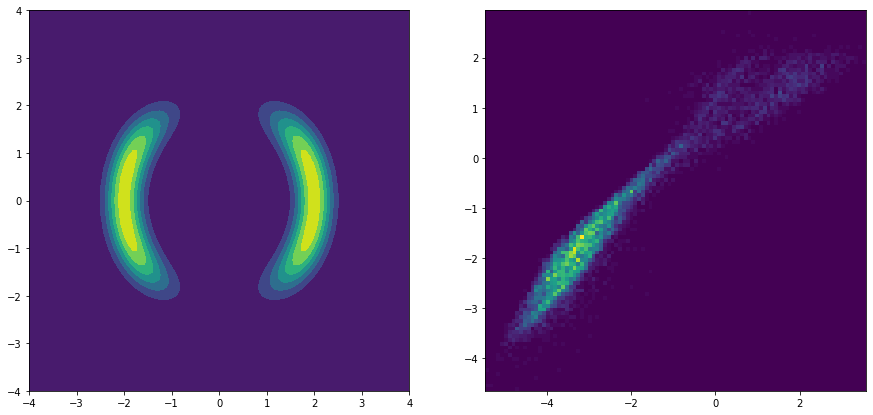

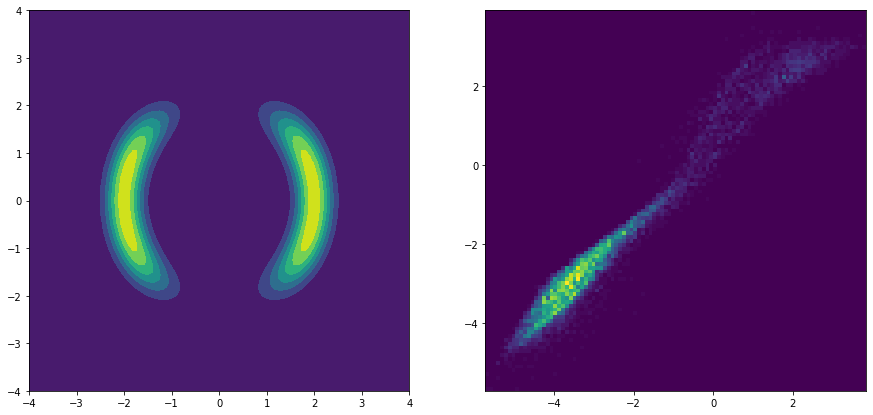

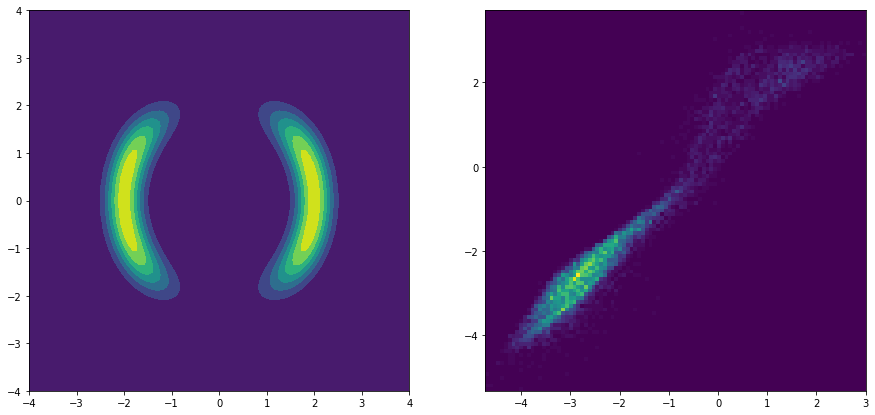

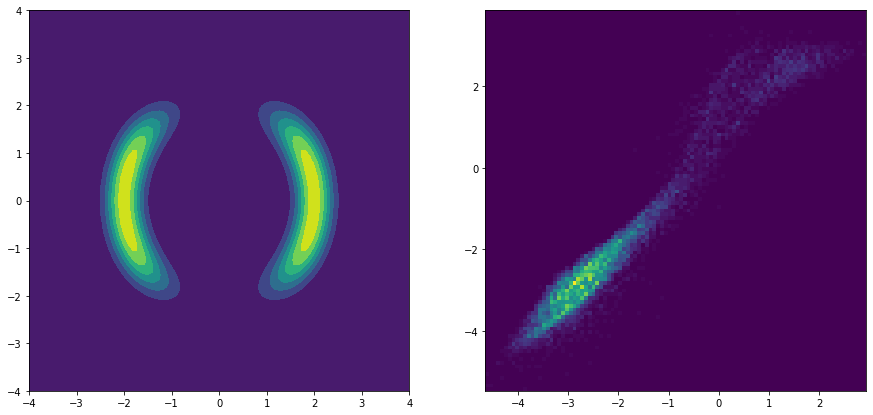

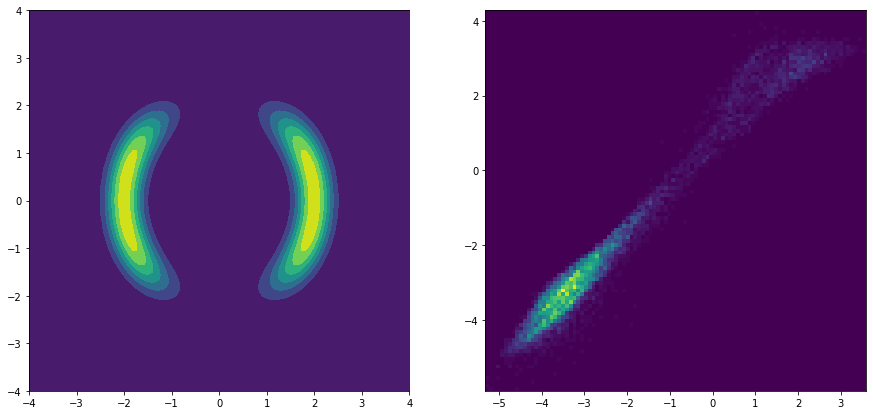

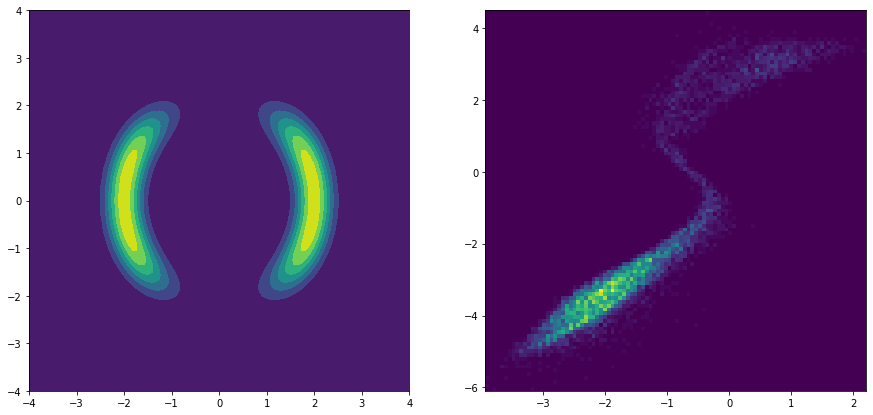

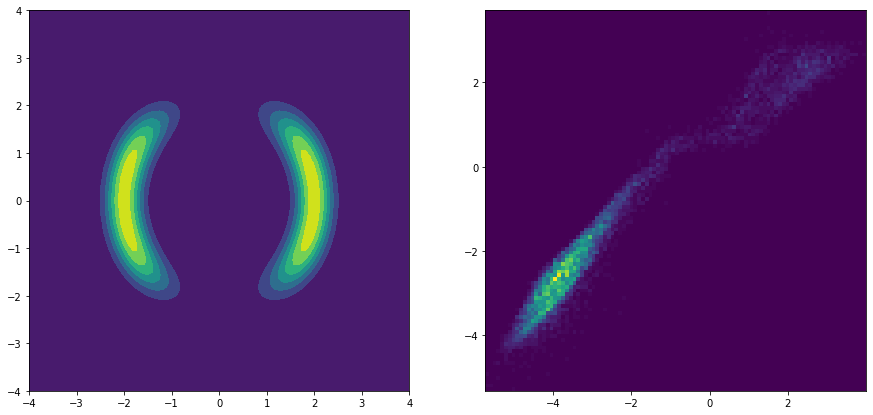

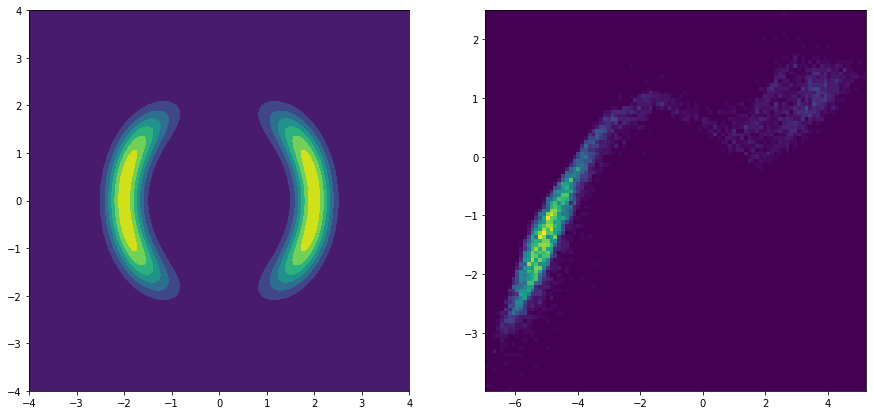

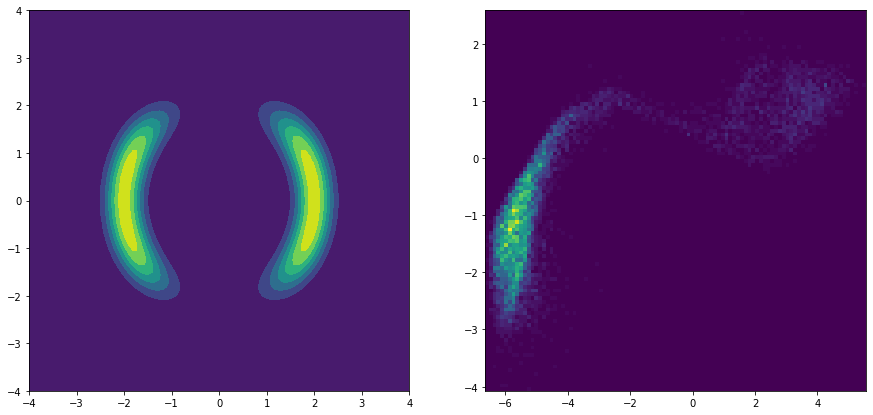

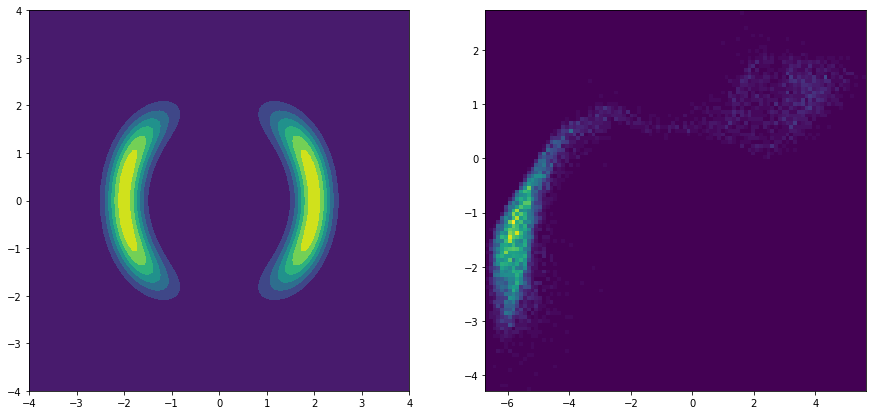

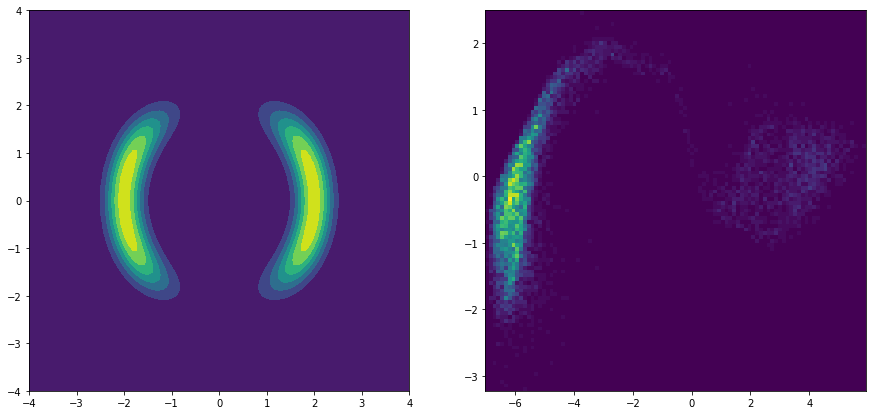

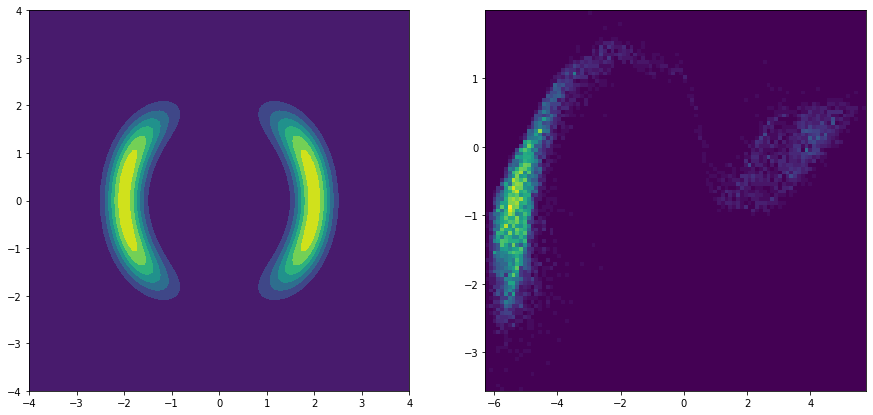

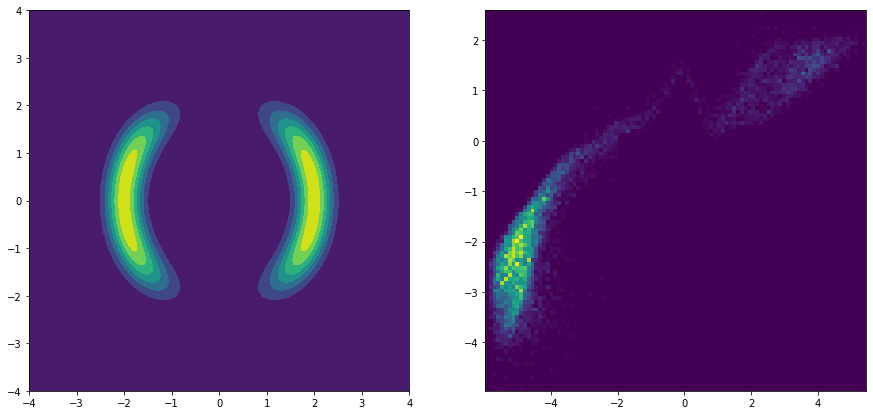

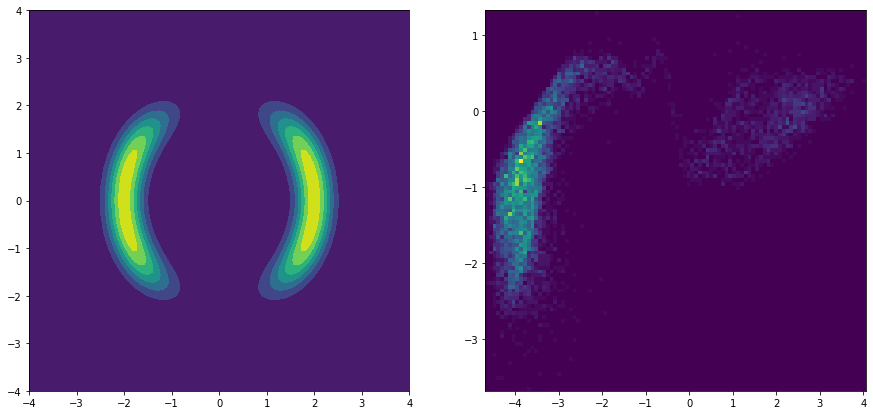

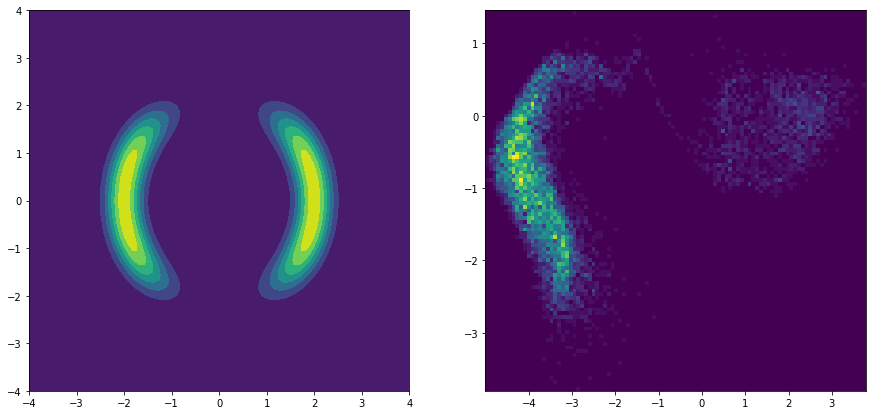

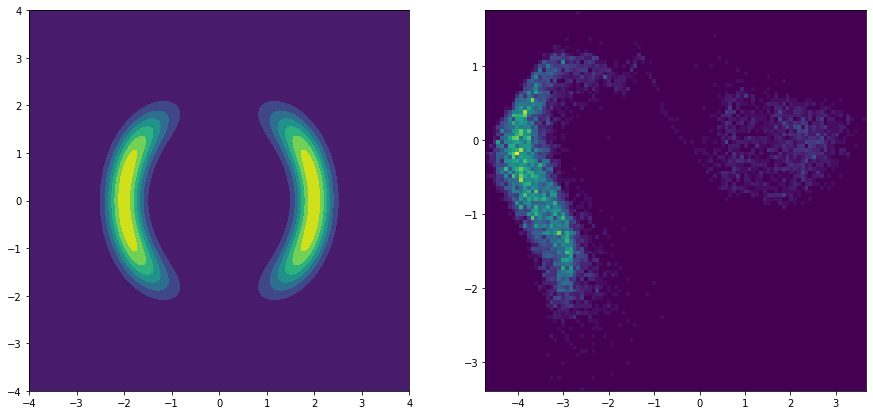

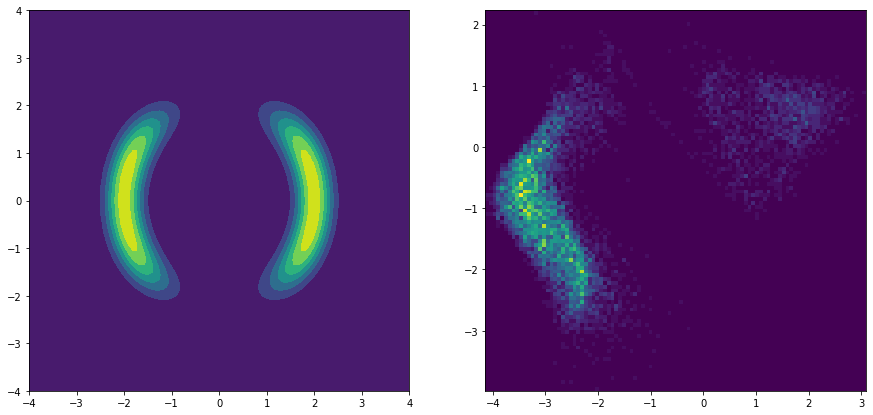

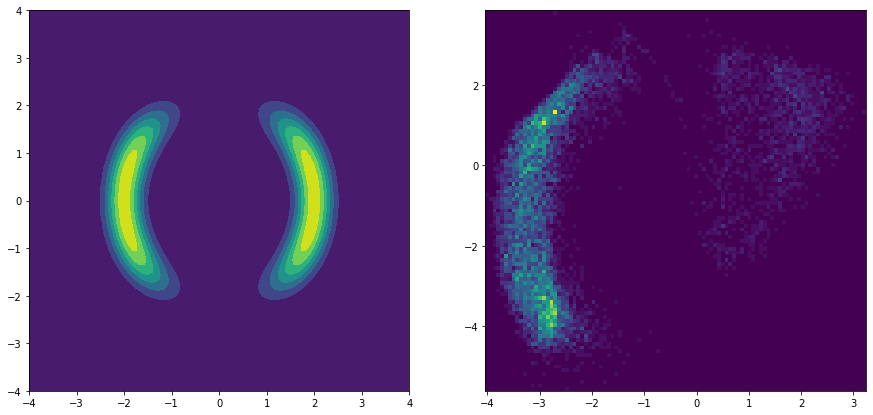

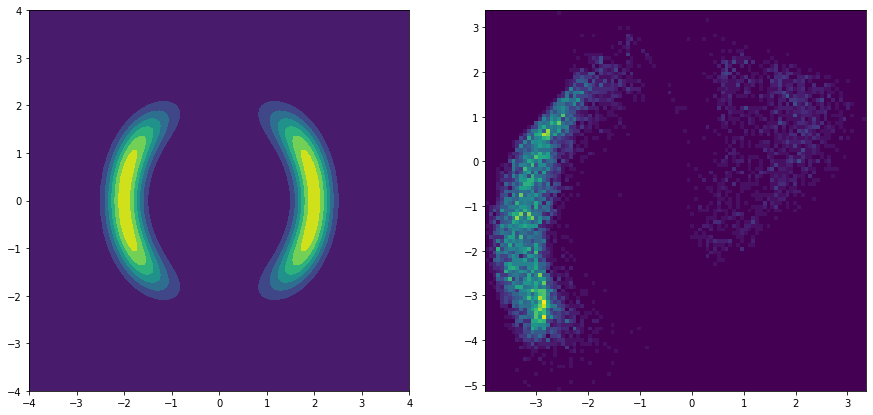

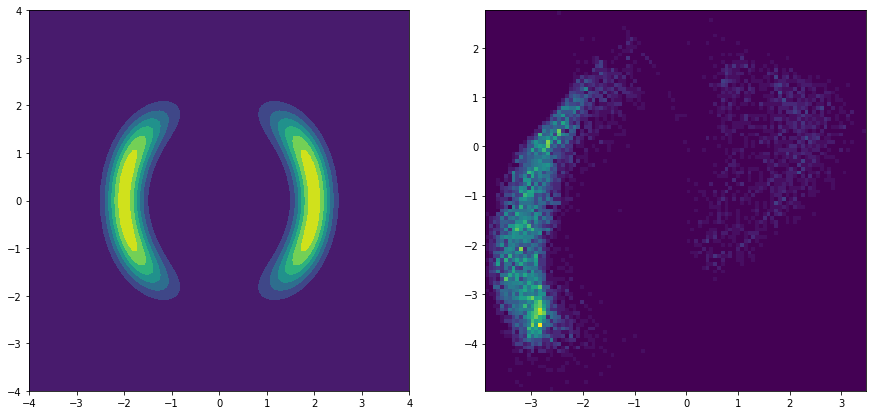

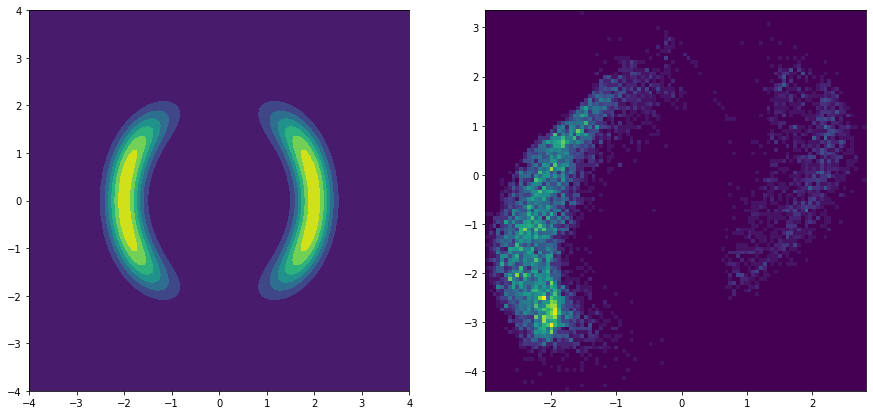

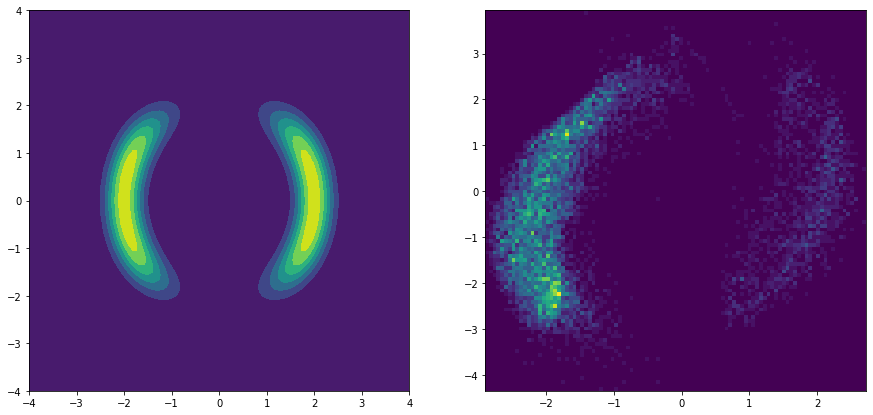

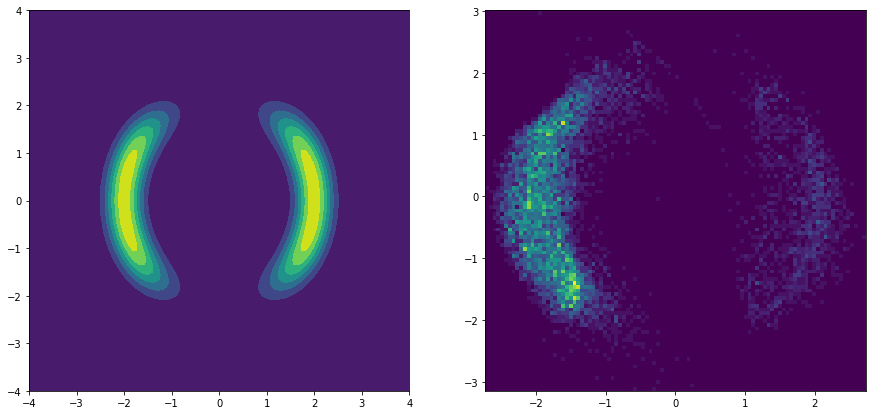

In [8]:
for i in range(len(z)):
    sample = z[i].detach().cpu().numpy()
    fig,ax = plt.subplots(1,2,figsize=(15,7))

    ax[0].contourf(xgrid, ygrid, zgrid1)
    ax[1].hist2d(sample[:,0],sample[:,1],bins=100)
    plt.show()

### $U_2$

In [9]:
planarFlows = [PlanarFlow(2) for k in range(32)]
model = NormalizingFlows(planarFlows)

model = model.to(device)

# optimizer = optim.RMSprop(model.parameters(),lr=1e-5,momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [10]:
train_loss = train_shapes(model, optimizer, U=U2p, n_epochs=10001)

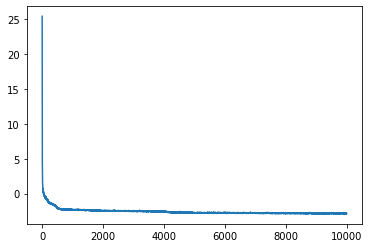

In [11]:
plt.plot(train_loss)
plt.show()

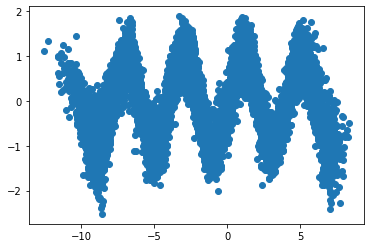

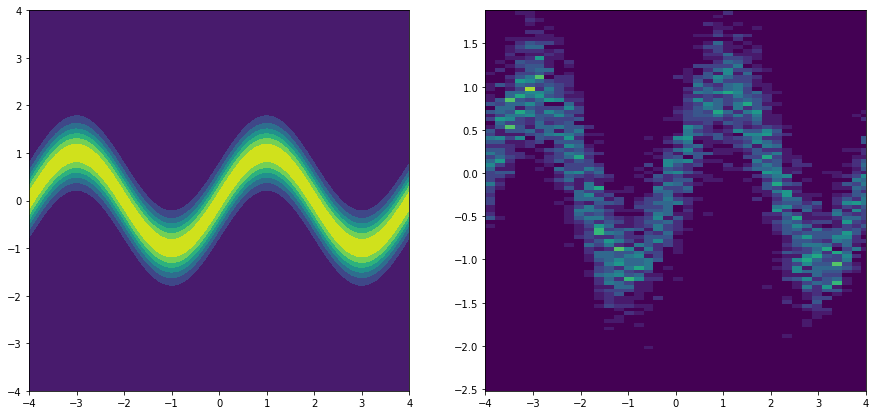

In [12]:
samples,_ = model(torch.randn(10000,2,device=device))
samples = samples[-1].detach().cpu().numpy()

plt.scatter(samples[:,0],samples[:,1])
plt.show()

fig,ax = plt.subplots(1,2,figsize=(15,7))

ax[0].contourf(xgrid, ygrid, zgrid2)
ax[1].hist2d(samples[:,0],samples[:,1],bins=100)
ax[1].set_xlim(-4,4)
plt.show()

## Variational Encoder with NF

ELBO:
We have:
\begin{align*}
    \log p_\theta(x)&\geq \log p_\theta(x)-KL(q(\cdot|x)||p_\theta(\cdot|x))\\
    &= \int \log(\frac{p_\theta(x,z)}{q(z|x)})q(z|x)dz \\
    &= \mathbb{E}_{q(\cdot|x)}[p_\theta(x|z)]-KL(q(\cdot|x)||p_\theta) \\
    &= -\mathcal{F}(\theta)
\end{align*}

**Variational Encoder**:
- encoder: $q_\phi(z|x)$
- decoder: $p_\theta(x|z)$

Example for classical VAE:
- encoder: $q_\phi(z|x)=\mathcal{N}(z;\mu,\sigma^2 I)$
- apriori: $p_\theta(z)=\mathcal{N}(z;0,I)$
- decoder: $p_\theta(x|z)=\mathcal{N}(x;\mu(z),\sigma^2(z))$ or $p_\theta(x|z)=\text{Ber}(D(z))$

**VAE with NF**: 

Idea: improve the class of distribution for the variational inference with a normalizing flow in the latent space (e.g. not just a mean field approximation with gaussians anymore).

- $q_0(z|x)=\mathcal{N}(z;\mu(x),\sigma^2(x))$

Let $z_0\sim q_0(\cdot|x)$,

- $z_K = f_K\circ\dots\circ f_1(z_0) = f(z_0)$
- $q_K(z_K|x) = q_0(z_0|x)|\det J_f(f^{-1}(z_K))|^{-1}$
- $\log q_K(z_K|x) = \log q_0(z_0|x) - \sum_{k=1}^K \log |\det \frac{\partial f_k}{\partial z_{k-1}}(z_{k-1})|$

Then, denoting $q_\phi=q_K$, the ELBO transforms as:

\begin{align*}
    \mathcal{F}(\theta,\phi) &= \mathbb{E}_{q_\phi}[\log q_\phi(z|x)-\log p_\theta(x,z)] \\
    &= \mathbb{E}_{q_0}[\log q_0(z_0|x)-\log p_\theta(x,f(z_0))-\sum_{k=1}^K \log |\det \frac{\partial f_k}{\partial z_{k-1}}(z_{k-1})|]
\end{align*}

In [13]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [14]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
#                 uniform_quantization,
#                 rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


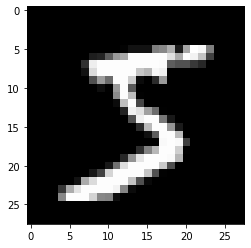

In [15]:
plt.imshow(train_dataset[0][0].reshape(28,28),"gray")
plt.show()

In [16]:
class Encoder(nn.Module):
    def __init__(self, d=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(28*28,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense_mean = nn.Linear(512,d)
        self.dense_log_var = nn.Linear(512,d)
        
    def forward(self, x):
        z = self.flatten(x)
        z = self.dense(z)
        z = self.leaky_relu(z)
        z_mean = self.dense_mean(z)
        z_log_var = self.dense_log_var(z)
        return z_mean, z_log_var


class Decoder(nn.Module):
    def __init__(self,d=10):
        super().__init__()
        self.dense = nn.Linear(d,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense2 = nn.Linear(512,28*28)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.dense(x)
        x = self.leaky_relu(x)
        x = self.dense2(x)
        x = self.sigmoid(x)
        return x.view(-1,28,28)
    
    
class VAE(nn.Module):
    def __init__(self,flow,d=10):
        super().__init__()
        self.encoder = Encoder(d)
        self.decoder = Decoder(d)
        self.flow = flow
    
    def forward(self, x):
        mu, log_sigma = self.encoder(x)        
        z0 = mu+torch.randn(mu.shape, device=device)*torch.exp(log_sigma)
        zKs, log_det = self.flow(z0)
        y = self.decoder(zKs[-1])
        return y, mu, log_sigma, log_det

In [17]:
planarFlows = [PlanarFlow(10) for k in range(2)]
flow = NormalizingFlows(planarFlows)

model = VAE(flow, d=10).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  820046


0 train_loss: 149.78793864734814 val_loss: 122.86521287619496


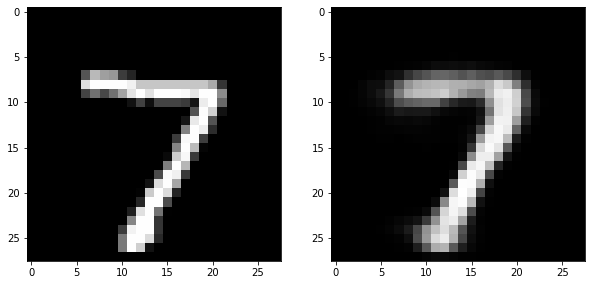

50 train_loss: 91.89727956721693 val_loss: 92.5441843343619


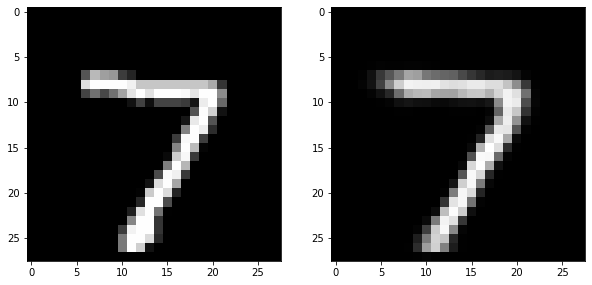

100 train_loss: 87.96150058944258 val_loss: 89.6304285945222


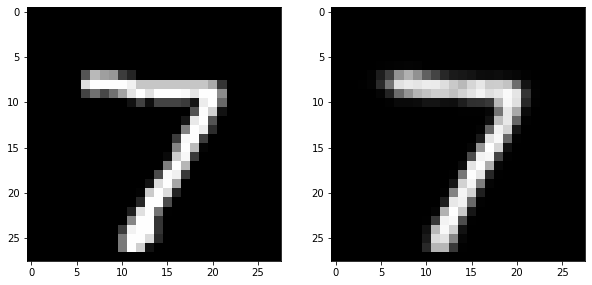

150 train_loss: 86.09003916986461 val_loss: 88.66021231264352


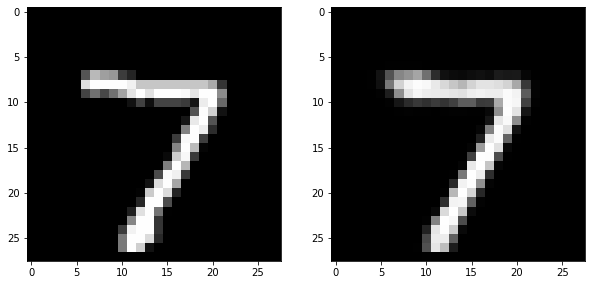

200 train_loss: 84.85365684200197 val_loss: 87.76241297615222


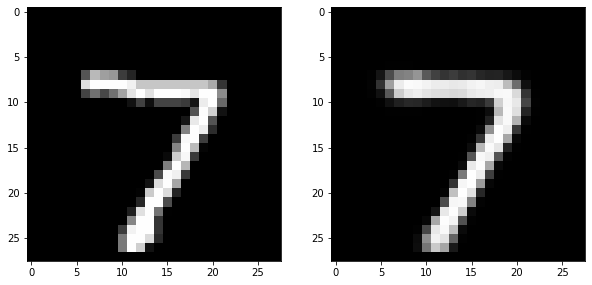

In [18]:
train_losses, val_losses = train_vae(model, optimizer, train_loader, test_loader=test_loader)

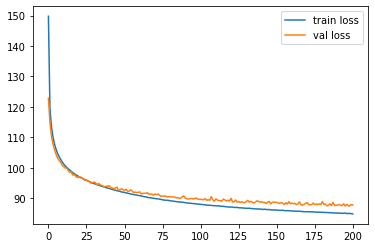

In [19]:
plt.plot(train_losses,label="train loss")
plt.plot(val_losses,label="val loss")
plt.legend()
plt.show()

To do:
- Log Likelihood estimation

## References

<a id="reference1"></a>

[1] Rezende, J.R., & Mohamed, S. Variational Inderence with Normalizing Flows. arXiv preprint arXiv:1505.05770. (2016). [link](https://arxiv.org/pdf/1505.05770)